# This notebook configures a CFM run for a single site, runs the CFM, and processes/plots the outputs.

### It should run if you put it in the CFM_main directory.

But it should still be considered in beta - please let me know if you have issues!

In [ ]:
#!/usr/bin/env python

import numpy as np 
import pandas as pd
import xarray as xr
import glob
import io
import multiprocessing
import sys
import os
import time
import json
import shutil
from pathlib import Path
from importlib import reload

"""
runCFM_notebook.ipynb
=======
This notebook configures a CFM run and then runs it.
- it goes in CFM_main 

- Forcing data need to go into a pandas dataframe (details in cell below)

- this notebook creates a .json configuration file
- CFM runs with the climate input and config file, results get put
  in the specified directory.
"""

### EDIT PATH HERE
sys.path.append('/Users/cvw30/Research/CommunityFirnModel/CFM_main')

from firn_density_nospin import FirnDensityNoSpin
import RCMpkl_to_spin as RCM

In [2]:
reload(RCM)

<module 'RCMpkl_to_spin' from 'c:\\Users\\cvw30\\Research\\CommunityFirnModel\\CFM_main\\RCMpkl_to_spin.py'>

In [3]:
### (optional) Set plot parameters (seaborn, matplotlib)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

In [4]:
timestep = '1d'
forcing_fp = f'CFMinput_example/gulkana_{timestep}_forcings.csv'
if not os.path.exists(forcing_fp):
    ### Example: build a dataframe with climate data
    ds = xr.open_dataset('../../Model/Output/gulkanaD_2025_08_18_0.nc') # example - open a file with climate data
    ds_tp = xr.open_dataset('../../Model/Output/gulkanaD_2025_08_18_climate.nc')['tp']

    # get sublimation from latent heat
    ds['sublim'] = ds.latent*3600/(2849000 * 1000) # latent (J s-1 m-2) * dt (s) / density_water (kg m-3) / lh_sub (J kg-1) --> m w.e.
    ds['sublim'][ds['sublim'] < 0] = 0
    ds['sublim'][ds.surftemp.values >= 0] = 0
    ds['sublim'] *= -1

    # add rain to ds
    ds['rain'] = ds_tp - ds['accum']
    ds['rain'][ds['rain'] < 0] = 0

    # change units of surftemp
    ds['surftemp'] += 273.15

    # resample to daily
    ds_mb = ds[['melt','accum','rain','sublim']].resample(time=timestep).sum() * 1000 # convert m w.e. to kg m-2
    ds_surftemp = ds[['surftemp']].resample(time='4h').mean()

    # merge
    data_in = xr.merge([ds_mb, ds_surftemp])
    data_in = data_in.rename_vars({'melt':'SMELT', 'rain':'RAIN', 'surftemp':'TS', 'accum':'BDOT','sublim':'SUBLIM'})

    df = data_in[['BDOT','RAIN','TS','SMELT','SUBLIM']].to_dataframe()
    df.to_csv(forcing_fp)
else:
    df = pd.read_csv(forcing_fp, index_col=0)
    df.index = pd.to_datetime(df.index)


This is the key bit to using the CFM this way - all of the forcing data goes into a pandas data frame with a datetime index.

Mass fluxes (ie., precip, sublimation) need to be in units $kg/m^{2}/dt$, where dt is the the time delta of the dataframe. So, if your input data units are $kg/m^{2}/s$, and the datetime index in your dataframe is daily resolution, you'll need to multiply by 86400 (seconds per day) to put the units in $kg/m^{2}/day$.

In [ ]:
### This function contains all of the CFM configuration options. You can change them, and the configuration gets stored as a .json file.
### The values here are more or less the defaults.

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput/test",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": true,
    "ReehCorrectedT": True,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": true,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": true,
    "grid_output_res": 0.25,
    "isoDiff": false,
    "iso": "NoDiffusion",
    "isoOptions":["18","D","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","meltoutputs"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": true,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True,
    "keep_firnthickness": true,
    "SEB_TL_thick": 0.05,
    "albedo_factor": 1
    }

    return c

c = makejson()
with open('my_configs.json', 'w') as file:
    json.dump(c, file)

In [8]:
tnow = time.time()
runid=-9999

### The CFM takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
### containing the vectors that the CFM needs to run.
### the function also returns some other variables that will be used to configure the CFM run.

#######
### Prepare config .json (which is a dictionary called c within this python script) ###
### edit as you wish here (the makejson function above just has defaults, you can change there as well)
### the edited json will be saved and used for the run.
c = makejson()

timeres = timestep #time resolution for the run, 5 days here (1 day is usually what I run, but slower)
sds = 1981.0 #spin date start
sde = 1995.0 #spin date end
runid = -9999 #arbitrary, but you can use this to keep track of runs

c['physRho'] = 'GSFC2020' # firn densification equation
c['runID'] = runid
c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.

c['SEB'] = False #surface energy balalnce module
c['MELT'] = True # whether to run melt module or not.
c['rain'] = True

### when I am doing gridded runs I keep track of coordinates here
lat_int=lat_val=-9999
lon_int=lon_val=-9999

c['lat_int'] = float(lat_int)
c['lon_int'] = float(lon_int)
c['lat_val'] = float(lat_val)
c['lon_val'] = float(lon_val)

'''
CFM regrids (merges) deeper nodes to save computation. There are 2 mergings
nodestocombine and multnodestocombine should be adjusted based on the time resolution of the run
e.g. if DFresample is '1d', nodestocombine = 30 will combine 30 layers at an intermediate depth, 
and multnodestocombine = 12 will combine 12 of those layers at a greater depth (which in this case 
will give 3 sections of firn - near the surface very thin layers, representing a day's accumulation,
middle, which is a month's accumulation, and deep, that should be a year's accumulation. 
e.g. if I am doing DFresample = '5d', I would set nodestocombine to 6 to still get layers that are a
month's worth of accumulation. (there is no 'best' way to do this - it is a bit of an art)
'''
c["doublegrid"] = True
c['nodestocombine'] = 30 
c['multnodestocombine'] = 12

### surface density (fixed or variable)
variable_srho = False
if variable_srho:
    c['variable_srho'] = True
    c['srho_type'] = "noise"
else:
    c['rhos0'] = 350.0 #e.g here you could change the surface density
    rhotype=f"rho{c['rhos0']}"
#######

rf_pre = 'CFMoutput_Annika'
rf_po = f'/CFMresults_{lat_val}_{lon_val}_{c["physRho"]}_notebook'

c['resultsFolder'] = rf_pre + rf_po #path (within CFM_main that the results will be stored in)

### format the CFM forcing data (including creating the spin up)
### climateTS is a dictionary with the various climate fields needed, in the correct units.
climateTS, StpsPerYr, depth_S1, depth_S2, grid_bottom, SEBfluxes = (
    RCM.makeSpinFiles(df,timeres=c['DFresample'],Tinterp='mean',spin_date_st = sds, 
    spin_date_end = sde, melt=c['MELT'], desired_depth = None, SEB=c['SEB'], rho_bottom=916))

# climateTS['SUBLIM'] = -1 * climateTS['SUBLIM'] #ADDED THIS FOR MERRA2 TO GET THE SIGN CORRECT.
climateTS['forcing_data_start'] = sds

c["stpsPerYear"] = float('%.2f' % (StpsPerYr))
c["stpsPerYearSpin"] = float('%.2f' % (StpsPerYr))
c["grid1bottom"] = float('%.1f' %(depth_S1))
c["grid2bottom"] = float('%.1f' %(depth_S2))
c["HbaseSpin"] = float('%.1f' %(3000 - grid_bottom))

c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 

c['keep_firnthickness'] = True
c['grid_outputs'] = True
c['grid_output_res'] = 0.05

configName = 'CFMconfig_{}_{}_{}.json'.format(lat_val,lon_val,c['physRho'])
if os.path.exists(os.path.join(c['resultsFolder'],configName)):
    CFMconfig = os.path.join(c['resultsFolder'],configName)
    shutil.move(CFMconfig, os.getcwd())
else:
    CFMconfig = configName

with open(CFMconfig,'w') as fp:
    fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

NewSpin = True # rerun the spin up each time if true

# dump results into pickle
with open('CFMinput_example/gulkana_config.json','w') as file:
    json.dump(c, file)
    print('saved config file')

### Create CFM instance by passing config file and forcing data, then run the model
firn = FirnDensityNoSpin(CFMconfig, climateTS = climateTS, NewSpin = NewSpin, SEBfluxes = SEBfluxes)
firn.time_evolve()
###
telap = (time.time()-tnow)/60
print('main done, {} minutes'.format(telap))

shutil.move(configName,os.path.join(c['resultsFolder'],configName))

saved config file
stepsperyear: 379.53938176979915
Spin run started
physics are GSFC2020
Grid length is 75526
AHL: 1.487473296321515
THL: 273.15
After doublegrid, grid length is  879
forcing_filename not in json. Defaulting to CFMforcing.hdf5
Main run starting
physics are GSFC2020
Initial LWC provided by spin-up
updatedStartDate 20.995289987068936
modeltime 1770.2868852459017 2025.2986301369863
estimated model run time (seconds): 717.1399212961197
WARM TEMPERATURES HAVE BEEN SET TO 273.15; MODEL RUN IS CONTINUING


c:\Users\cvw30\Research\CommunityFirnModel\CFM_main\physics.py:1205: RuntimeWarning: invalid value encountered in power
  c1 = ar1 * A_mean_1**alpha1 * GRAVITY * np.exp(-Ec1 / (R * self.Tz[self.rho < RHO_1]) + Eg / (R * self.T_mean[self.iii]))
c:\Users\cvw30\Research\CommunityFirnModel\CFM_main\physics.py:1206: RuntimeWarning: invalid value encountered in power
  c2 = ar2 * A_mean_2**alpha2 * GRAVITY * np.exp(-Ec2 / (R * self.Tz[self.rho >= RHO_1]) + Eg / (R * self.T_mean[self.iii]))


IndexError: index -1 is out of bounds for axis 0 with size 0

In [57]:
# put the results in a dictionary, which is convenient if you do multiple similar runs
fns = ['GSFC2020']
rd = {} #results dictionary
for rt in fns:
    print(rt)
    rd[rt] = {}
    results_dir = f'CFMresults_{rt}_notebook'
    with xr.open_dataset(Path(f'{results_dir}/CFMresults.hdf5')) as fn: # Open the CFM results file
    # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
    # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[rt]['model_time'] = fn['density'][1:,0] # the first column of the density data is the model time step.
        rd[rt]['depth'] = fn['depth'][1:] # Put the depth data into a numpy array
        rd[rt]['density'] = fn['density'][1:,1:] # Put the density data into an array
        rd[rt]['temperature'] = fn['temperature'][1:,1:]
        rd[rt]['LWC'] = fn['LWC'][1:,1:]
        rd[rt]['DIP_time'] = fn['DIP'][1:,0]
        rd[rt]['DIP'] = fn['DIP'][1:,1:]
        fn.close() # Close the file

GSFC2020


Text(0, 0.5, 'Depth (m)')

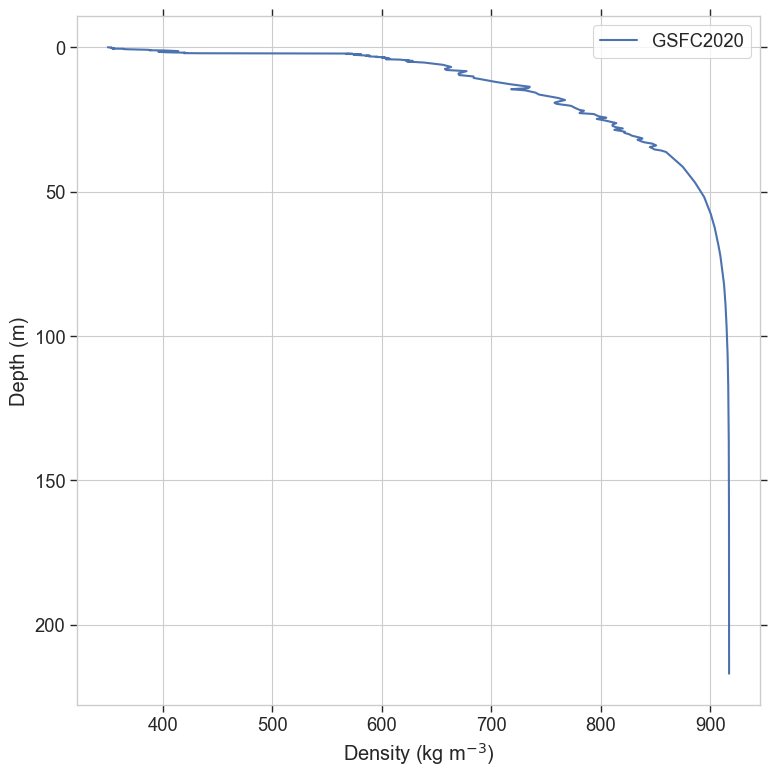

In [48]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Temp (K)')

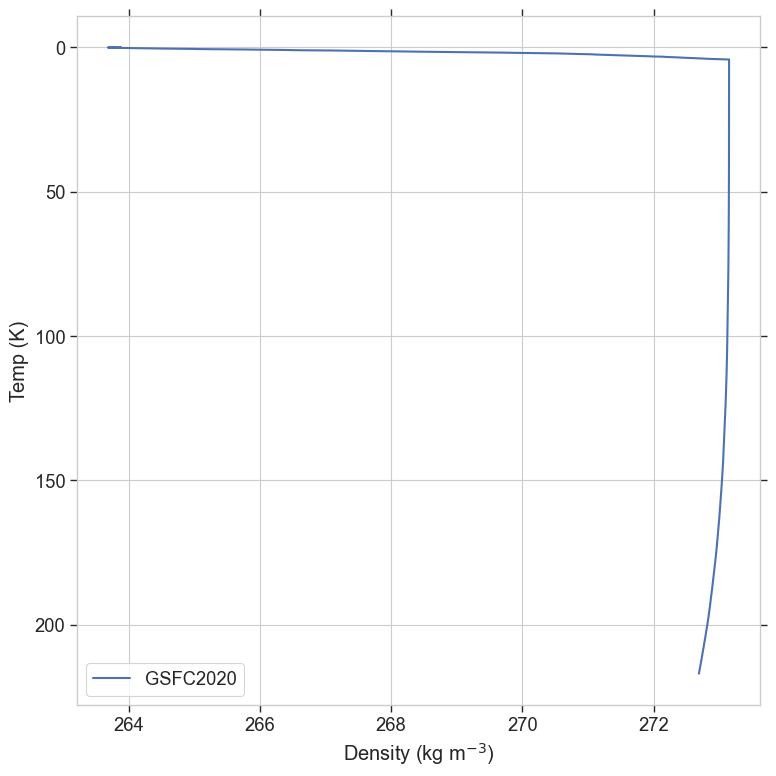

In [51]:
### Plot depth/temperature
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['temperature'][-1,:],rd[rt]['depth'],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Temp (K)')

Text(0, 0.5, 'LWC (m$^{3}$)')

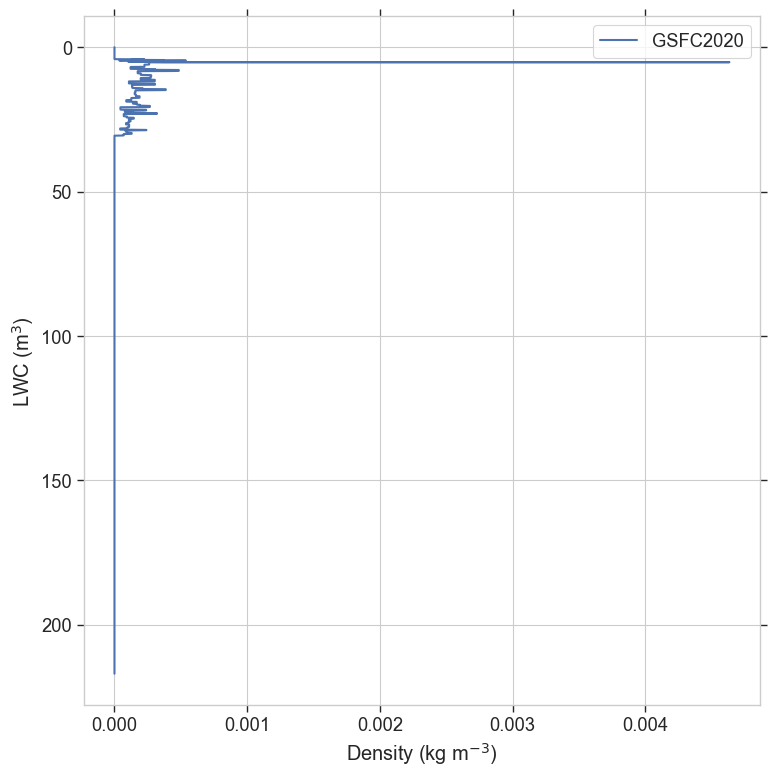

In [52]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['LWC'][-1,:],rd[rt]['depth'],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('LWC (m$^{3}$)')

Text(0, 0.5, 'Firn Air content (m)')

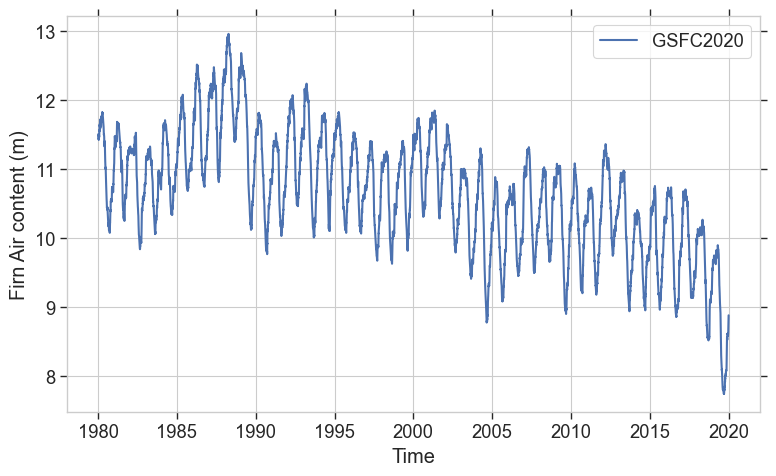

In [60]:
### Plot FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['DIP_time'][:],rd[rt]['DIP'][:,0],label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('Firn Air content (m)')

Text(0, 0.5, 'Firn Air content anomaly (m)')

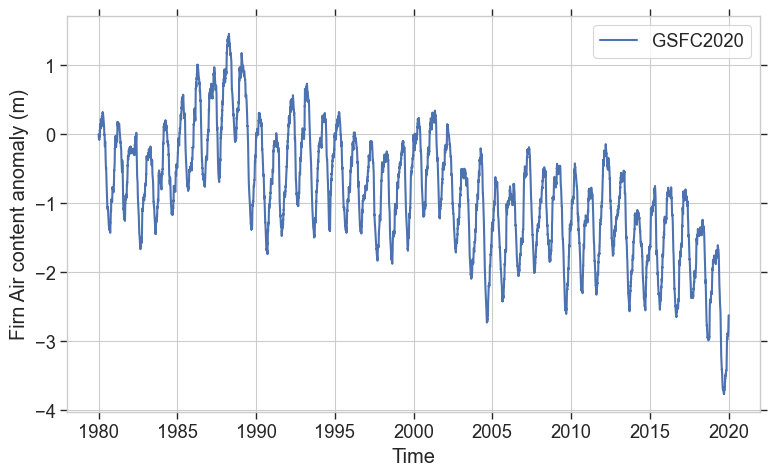

In [62]:
### Plot FAC anomaly (relative to 1980) through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['DIP_time'][:],rd[rt]['DIP'][:,0]-rd[rt]['DIP'][0,0] ,label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('Firn Air content anomaly (m)')